# Agent interaction analysis
## Step by step data extraction

In [2]:
# Imports
import pandas as pd
# from egg.core.interaction import Interaction
import torch
from sklearn.decomposition import PCA
from pathlib import Path
from matplotlib import pyplot as plt
# used in a later part of the script :
# import seaborn as sns

In [3]:
# Path to your interaction file
import os
path_to_interaction = Path("/Users/u203445/Documents/projects/EGG/")
inter = torch.load(path_to_interaction / "cont_interactions_2")


In [4]:
cont_messages = torch.cat([a for a in inter.message])
print("mean = ",cont_messages.mean().item())
print("standard deviation = ",cont_messages.std().item())


mean =  0.4151911735534668
standard deviation =  0.2668488621711731


In [5]:
def interaction_to_dataframe(interaction):
    """
    Function to turn the Interaction file into a pandas DataFrame which is covered with syntaxic sugar so easy to use
    """
    df = pd.DataFrame()
    # skipped as is empty in the emecom_pop case
    # df["sender_input"] = interaction.sender_input
    # df["receiver_input"] = interaction.receiver_input
    df["labels"] = interaction.labels
    for key in interaction.aux_input:
        if key == "receiver_message_embedding": # in continuous format message and receiver embedding are the same
            for dim, value in enumerate(interaction.message.T):
                df[f"dim_{dim}"] = value
        else:
            df[key] = interaction.aux_input[key]
    df["receiver_output"] = [i.argmax().item() for i in interaction.receiver_output]

    return df

In [6]:
df_inter = interaction_to_dataframe(inter)
# quick overview of what the dataframe looks like
# the function .sample(10) randomly selects 10 elements from the DataFrame
print(df_inter.sample(3))

       labels  sender_idx  recv_idx  loss_idx  batch_number     dim_0  \
69002      14           3         1         0          4106  0.135916   
38980      62           1         3         0          4036  0.238356   
34665      27           1         2         0          4713  0.924283   

          dim_1     dim_2     dim_3     dim_4  ...     dim_7     dim_8  \
69002  0.448479  0.570727  0.246712  0.643286  ...  0.318441  0.511119   
38980  0.238515  0.791435  0.297880  0.640359  ...  0.881119  0.115595   
34665  0.691256  0.283571  0.527491  0.022379  ...  0.890249  0.601017   

          dim_9    dim_10    dim_11    dim_12    dim_13    dim_14    dim_15  \
69002  0.652323  0.477946  0.477126  0.312074  0.133204  0.138863  0.466992   
38980  0.311210  0.173546  0.199583  0.257758  0.126722  0.122870  0.239357   
34665  0.366422  0.063264  0.192159  0.489636  0.557052  0.320890  0.710396   

       receiver_output  
69002               10  
38980                4  
34665             

## Begining of a PCA analysis
lets make a 2 component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

In [7]:
# select which sender to analyse
# chosen_sender_index = [0,1,2,3]
_chosen_sender_index = [2,3]
# taking only the interactions that have the matching indexes for the sender
selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)]

In [30]:
# Doing the actual PCA
n_components=10
pca = PCA(n_components)
x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i+1}' for i in range(n_components)])

# adding the labels for colouring purposes in plot
df_pca['labels'] = selectedsender_interactions.labels.values
print(df_pca.sample(3))

       principal component 1  principal component 2  principal component 3  \
33523              -0.225001              -0.293475              -0.219854   
3184               -0.125756              -0.369052               0.597974   
12843               0.469051              -0.272601              -0.414218   

       principal component 4  principal component 5  principal component 6  \
33523               0.451083               0.002654              -0.288595   
3184               -0.328026              -0.246284              -0.018781   
12843               0.135790              -0.233847               0.295035   

       principal component 7  principal component 8  principal component 9  \
33523               0.114576               0.315156               0.277029   
3184                0.101537              -0.000901               0.499174   
12843              -0.401207               0.007159              -0.285841   

       principal component 10  labels  
33523                

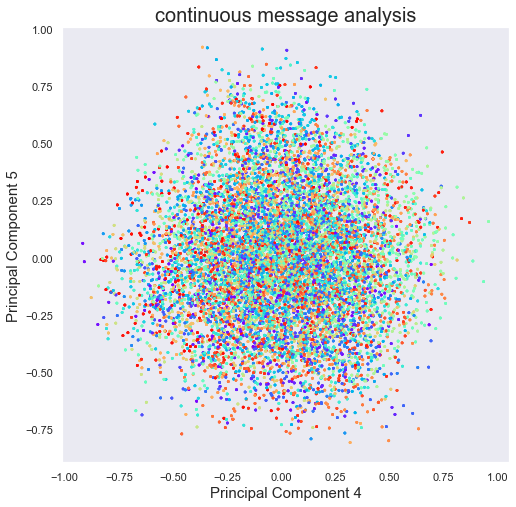

In [38]:
# plotting the PCA (and realising these dimensions ain't helping for clustering...)

# Chose here which components you want to look at (they're all terrible) 
prin_comp_A = 4
prin_comp_B = 5

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component {prin_comp_A}', fontsize = 15)
ax.set_ylabel(f'Principal Component {prin_comp_B}', fontsize = 15)
ax.set_title('continuous message analysis', fontsize = 20)
colors = plt.cm.rainbow(torch.arange(0, 1, 0.01))

# here I´m colouring the different classes with different colours
ax.scatter(df_pca[f'principal component {prin_comp_A}']
            , df_pca[f'principal component {prin_comp_B}']
            , color = colors[df_pca['labels']]
            , s = 3)
ax.grid()

## Some other basic stuff

In [10]:
import seaborn as sns

In [11]:
melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
print(melted_df.sample(3))

         sender_idx  loss_idx  recv_idx  labels  receiver_output  \
1083510           2         0         1      35               54   
920189            2         0         0      32               61   
197898            1         0         3      70               10   

         batch_number     dim  message_value  
1083510           246  dim_13       0.277013  
920189           1661  dim_11       0.584522  
197898           3210   dim_2       0.615501  


<AxesSubplot:xlabel='dim', ylabel='message_value'>

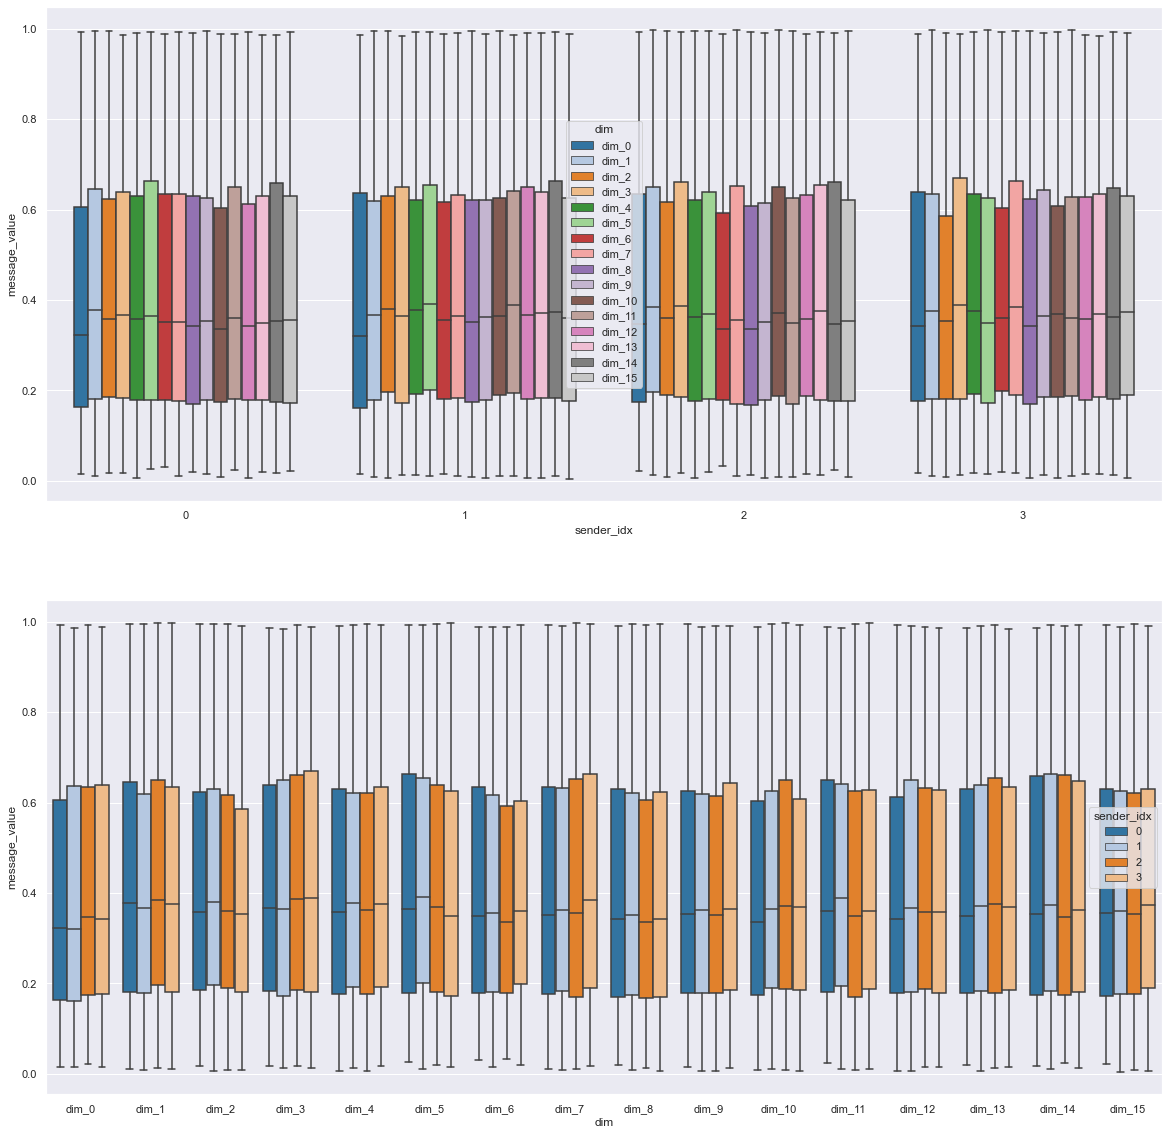

In [19]:
#lets check messages are evenly distributed accross dimensions and senders
fig, axes = plt.subplots(2,1) 

sns.set(rc={'figure.figsize':(20,20)})
sns.boxplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0])
sns.boxplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1])

# This does not seem to call for further statistical testing... quite similar, they've all gone through a sigmoid. Might still check to be sure.

In [21]:
# change the index of the sender to analyse here :
sender_idx = 3

<AxesSubplot:xlabel='dim', ylabel='message_value'>

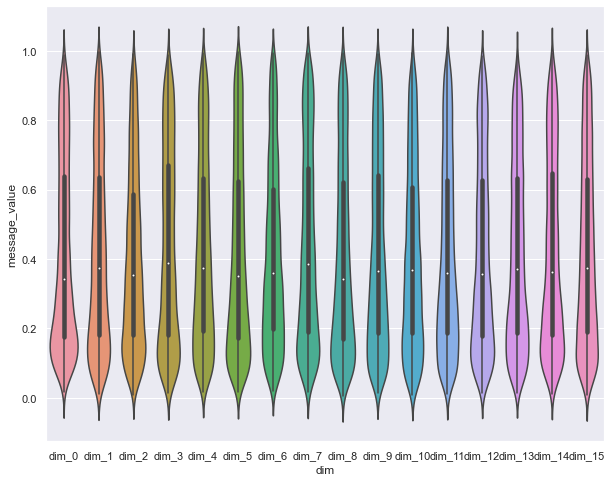

In [23]:
sns.set(rc={'figure.figsize':(10,8)})
sns.violinplot(x=melted_df[melted_df.sender_idx == sender_idx].dim, y=melted_df[melted_df.sender_idx == sender_idx].message_value)
# This tends to give an idea of what the saturation point is for the sigmoid... I'd set it around 0.35

C:\Users\u203445\AppData\Local\Temp\ipykernel_16388\3231260858.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_16388\3231260858.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_16388\3231260858.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_16388\3231260858.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
C:\Users\u203445\AppData\Local\Temp\ipykernel_16388\3231260858.py:4: UserWarning: Boolean Series key wil

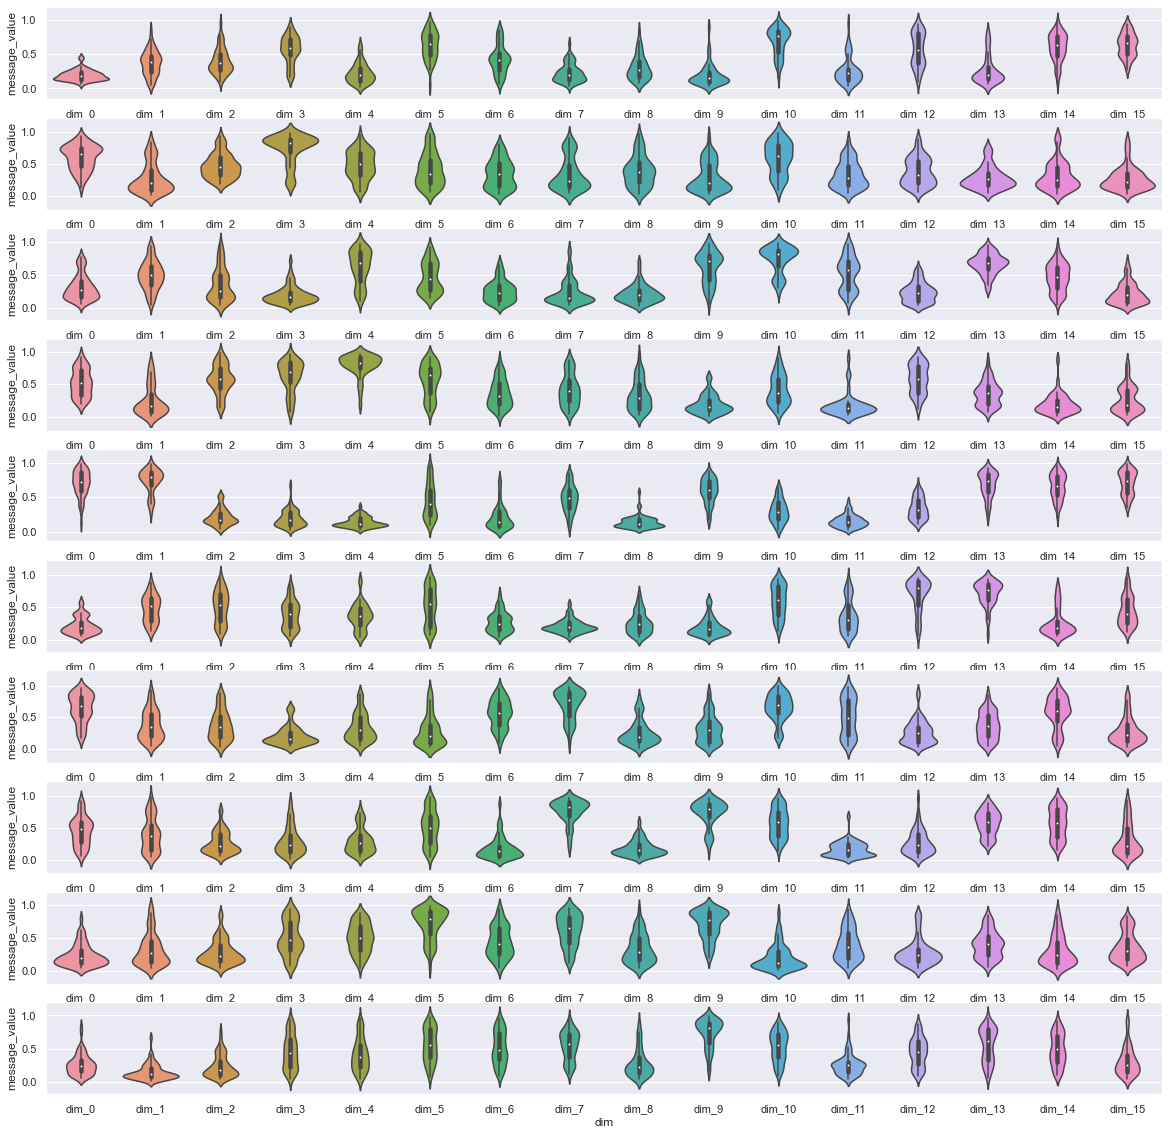

In [28]:
sns.set(rc={'figure.figsize':(20,20)})
fig, axes = plt.subplots(10,1) 
for i, label in enumerate(melted_df.labels.sample(10)):
    _df = melted_df[melted_df.sender_idx == sender_idx][melted_df.labels==label]
    if len(_df) != 0:
        sns.violinplot(x=_df.dim, y=_df.message_value, ax=axes[i])